![Course header](../assets/img/header.png)

# 03 — STAC Fundamentals
Search, filter, and preview satellite data using a real STAC API

This notebook introduces the **SpatioTemporal Asset Catalog (STAC)** standard.
You will use the Microsoft Planetary Computer STAC API to find Sentinel‑2 scenes.

## Learning Objectives

This notebook serves as a **quick reference** for STAC discovery. If you're already comfortable with STAC, feel free to skim or skip ahead to Notebook 05.

By the end of this notebook, you will be able to:

- Explain what STAC is and why it matters for EO data discovery
- Connect to a STAC API and list available collections
- Search for satellite imagery by area, time, and cloud cover
- Inspect Item metadata and assets
- Build a results table with pandas
- Preview a band from a STAC Item
- Export results for reuse

Tooling in this notebook:
- pystac-client
- planetary-computer
- pandas
- matplotlib
- rioxarray

We keep the AOI small and the number of Items low to stay fast.

---

## How to use this notebook

1. Run cells in order.
2. Keep bbox small.
3. If you get empty results, loosen filters (wider time range or higher cloud threshold).
4. If something breaks, restart kernel and run all.

---

## Table of contents

1. Setup
2. What is STAC?
3. Connect to a STAC API
4. Define a search area (bbox)
5. Search for Sentinel-2 images
6. Inspect Item metadata and assets
7. Build a results table with pandas
8. Preview a band from a STAC Item
9. Export results
10. Exercises
11. Recap

---

## 1) Setup


In [30]:
### Install (if necessary)
!pip install pystac-client numpy pandas matplotlib planetary-computer rioxarray

  Using cached rioxarray-0.21.0-py3-none-any.whl.metadata (5.4 kB)
  Using cached rasterio-1.5.0-cp314-cp314-macosx_14_0_arm64.whl.metadata (8.6 kB)
  Using cached xarray-2025.11.0-py3-none-any.whl.metadata (12 kB)
  Using cached pyproj-3.7.2-cp314-cp314-macosx_14_0_arm64.whl.metadata (31 kB)
  Using cached affine-2.4.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached cligj-0.7.2-py3-none-any.whl.metadata (5.0 kB)
Using cached rioxarray-0.21.0-py3-none-any.whl (64 kB)
Using cached xarray-2025.11.0-py3-none-any.whl (1.4 MB)
Using cached pyproj-3.7.2-cp314-cp314-macosx_14_0_arm64.whl (4.6 MB)
Using cached rasterio-1.5.0-cp314-cp314-macosx_14_0_arm64.whl (22.8 MB)
Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
Using cached affine-2.4.0-py3-none-any.whl (15 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [rioxarray]/6 [xarray]o]


### Imports

In [7]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pystac_client
import planetary_computer


### Paths
Outputs go to `../outputs/`.

In [8]:
OUT_DIR = Path('..') / 'outputs'
OUT_DIR.mkdir(exist_ok=True)
OUT_DIR.resolve()

PosixPath('/Users/stevenhill/Work/EORC/Courses/cubes_and_clouds_python/eo_python_foundations/outputs')

---

## 2) What is STAC?

**STAC** (SpatioTemporal Asset Catalog) is a specification for describing geospatial data.
It has become the standard for organising and discovering satellite imagery in the cloud.

Key Specifications:

- **Metadata Standardization:** STAC defines a set of core metadata fields that describe the essential information about a geospatial asset, such as its spatial and temporal extents, cloud cover, and licensing information.

- **Searchability:** STAC enables efficient searching and discovery of geospatial assets based on their spatiotemporal characteristics. This is particularly valuable in scenarios where users need to find specific datasets within a vast collection.

- **Modularity:** STAC is designed to be modular, allowing for extensions to the core specification. This enables communities or organizations to add domain-specific metadata fields to address their particular needs while still adhering to the overall STAC structure.

- **JSON Format:** STAC metadata is typically provided in JSON (JavaScript Object Notation) format, making it human-readable and easy to parse by machines. This choice of format facilitates interoperability and integration with web technologies.

- **Versioning:** STAC is versioned to ensure compatibility and provide a clear understanding of the specification's evolution. Users can refer to specific versions of the STAC specification to understand the metadata structure used in a particular dataset.

**STAC Components**

| Component      | Description                          | Example                                |
|----------------|--------------------------------------|----------------------------------------|
| **Catalog**    | The root entry point                 | Planetary Computer, Earth Search       |
| **Collection** | A group of related Items             | Sentinel-2 L2A, Landsat 8             |
| **Item**       | A single observation (one scene)     | One Sentinel-2 granule on 2024-06-15  |
| **Asset**      | A file associated with an Item       | Red band GeoTIFF, thumbnail PNG       |

### Why STAC?

Before STAC, every data provider had their own API and query syntax.
With STAC:

- **Standardised** — the same query works across providers
- **Cloud-native** — direct links to COGs (Cloud-Optimised GeoTIFFs), no bulk download needed
- **Rich metadata** — spatial extent, temporal coverage, cloud cover, band info, etc.

Think of STAC as a **library catalogue for satellite images**: you search the catalogue first, then load only the data you need.

<p align="center"> <img src="../assets/img/stac.png" style="width:600px;"> </p>
<sub>https://mohr.ws/foss4g/</sub>

**Example Earth observation STAC catalogs**

- [Microsoft Planetary Computer (STAC API)](https://planetarycomputer.microsoft.com/api/stac/v1/)  ￼
- [Amazon Web Services Earth Search / Element 84 (STAC API)](https://earth-search.aws.element84.com/v1/)  ￼
- [Copernicus Data Space Ecosystem (STAC API)](https://stac.dataspace.copernicus.eu/v1/)  ￼
- [European Space Agency EO-CAT (STAC API)](https://eocat.esa.int/eo-catalogue/)  ￼
- [U.S. Geological Survey LandsatLook (STAC)](https://landsatlook.usgs.gov/stac-server/)  ￼
- [Radiant MLHub (STAC API)](https://api.radiant.earth/mlhub/v1/)  ￼
- [Google Earth Engine STAC (static catalog.json)](https://earthengine-stac.storage.googleapis.com/catalog/catalog.json)



---

## 3) Connect to a STAC API

We use **Microsoft Planetary Computer**. It hosts Sentinel-2, Landsat, and many other collections.

Planetary Computer requires **signed URLs** — the `planetary_computer.sign_inplace` modifier handles that automatically.

In [9]:
STAC_API_URL = 'https://planetarycomputer.microsoft.com/api/stac/v1'

In [10]:

catalog = pystac_client.Client.open(
    STAC_API_URL,
    modifier=planetary_computer.sign_inplace,
)
print(f'Connected to: {catalog.title}')

Connected to: Microsoft Planetary Computer STAC API


### 3.1 List available collections

A STAC Catalog can host many Collections. Let's see a selection.

In [11]:
collections = list(catalog.get_collections())
collections

[<CollectionClient id=daymet-annual-pr>,
 <CollectionClient id=daymet-daily-hi>,
 <CollectionClient id=3dep-seamless>,
 <CollectionClient id=3dep-lidar-dsm>,
 <CollectionClient id=fia>,
 <CollectionClient id=gridmet>,
 <CollectionClient id=daymet-annual-na>,
 <CollectionClient id=daymet-monthly-na>,
 <CollectionClient id=daymet-annual-hi>,
 <CollectionClient id=daymet-monthly-hi>,
 <CollectionClient id=daymet-monthly-pr>,
 <CollectionClient id=gnatsgo-tables>,
 <CollectionClient id=hgb>,
 <CollectionClient id=cop-dem-glo-30>,
 <CollectionClient id=cop-dem-glo-90>,
 <CollectionClient id=terraclimate>,
 <CollectionClient id=nasa-nex-gddp-cmip6>,
 <CollectionClient id=gpm-imerg-hhr>,
 <CollectionClient id=gnatsgo-rasters>,
 <CollectionClient id=3dep-lidar-hag>,
 <CollectionClient id=io-lulc-annual-v02>,
 <CollectionClient id=goes-cmi>,
 <CollectionClient id=conus404>,
 <CollectionClient id=sentinel-1-rtc>,
 <CollectionClient id=3dep-lidar-intensity>,
 <CollectionClient id=3dep-lidar-point

In [12]:
# Print collections whose names contain common EO keywords
print('Selected Collections:')
keywords = ['sentinel', 'landsat']
for collection in catalog.get_collections():
    if any(kw in collection.id.lower() for kw in keywords):
        print(f'  {collection.id}: {collection.title}')

Selected Collections:
  sentinel-1-rtc: Sentinel 1 Radiometrically Terrain Corrected (RTC)
  landsat-c2-l2: Landsat Collection 2 Level-2
  sentinel-2-l2a: Sentinel-2 Level-2A
  landsat-c2-l1: Landsat Collection 2 Level-1
  sentinel-1-grd: Sentinel 1 Level-1 Ground Range Detected (GRD)
  sentinel-5p-l2-netcdf: Sentinel-5P Level-2
  sentinel-3-olci-wfr-l2-netcdf: Sentinel-3 Water (Full Resolution)
  sentinel-3-synergy-aod-l2-netcdf: Sentinel-3 Global Aerosol
  sentinel-3-synergy-v10-l2-netcdf: Sentinel-3 10-Day Surface Reflectance and NDVI (SPOT VEGETATION)
  sentinel-3-olci-lfr-l2-netcdf: Sentinel-3 Land (Full Resolution)
  sentinel-3-sral-lan-l2-netcdf: Sentinel-3 Land Radar Altimetry
  sentinel-3-slstr-lst-l2-netcdf: Sentinel-3 Land Surface Temperature
  sentinel-3-slstr-wst-l2-netcdf: Sentinel-3 Sea Surface Temperature
  sentinel-3-sral-wat-l2-netcdf: Sentinel-3 Ocean Radar Altimetry
  sentinel-3-slstr-frp-l2-netcdf: Sentinel-3 Fire Radiative Power
  sentinel-3-synergy-syn-l2-netcdf:

---

## 4) Define a search area (bbox)

We define an **area of interest (AOI)** as a bounding box:

```
(west, south, east, north)
```

in geographic coordinates (longitude / latitude).

Keep it small — a few kilometres is enough for this exercise.

In [13]:
# AOI: small area near Würzburg, Germany
AOI_BBOX = (9.95, 49.78, 10.05, 49.83)

print(f'West:  {AOI_BBOX[0]}')
print(f'South: {AOI_BBOX[1]}')
print(f'East:  {AOI_BBOX[2]}')
print(f'North: {AOI_BBOX[3]}')

West:  9.95
South: 49.78
East:  10.05
North: 49.83


---

## 5) Search for Sentinel-2 images

We search the `sentinel-2-l2a` collection (Level-2A = surface reflectance) with filters:

- **bbox** — spatial extent
- **datetime** — time range
- **query** — cloud cover threshold

In [14]:
# Search parameters
DATE_RANGE = '2024-06-01/2024-06-30'
MAX_CLOUD = 40  # percent

search = catalog.search(
    collections=['sentinel-2-l2a'],
    bbox=AOI_BBOX,
    datetime=DATE_RANGE,
    query={'eo:cloud_cover': {'lt': MAX_CLOUD}},
)

items = list(search.items())
print(f'Found {len(items)} items with cloud cover < {MAX_CLOUD}%')

Found 6 items with cloud cover < 40%


| Parameter | Type (typical) | What it does | Example |
|---|---|---|---|
| `collections` | `list[str]` | Restrict search to one or more Collection IDs | `["sentinel-2-l2a"]` |
| `ids` | `list[str]` | Return specific Items by ID (most other filters become unnecessary) | `["S2A_..."]` |
| `bbox` | `tuple[float, float, float, float]` | Area-of-interest bounding box `(west, south, east, north)` in lon/lat | `(9.95, 49.78, 10.05, 49.83)` |
| `intersects` | `dict` (GeoJSON geometry) | Spatial filter using a geometry (Polygon/MultiPolygon/etc.) instead of a bbox | `{"type":"Polygon","coordinates":[...]} ` |
| `datetime` | `str` | Time instant or interval (`"start/end"`), supports open intervals with `..` | `"2024-06-01/2024-06-30"`, `"2024-06-01/.."` |
| `query` | `dict` | Simple property filtering using STAC Query operators (`lt`, `gt`, etc.); server support varies | `{"eo:cloud_cover": {"lt": 40}}` |
| `filter` | `str` or `dict` | Advanced filtering using CQL2 (Filter extension required) | `"eo:cloud_cover < 10"` (with `filter_lang="cql2-text"`) |
| `filter_lang` | `str` | Declares filter syntax: `"cql2-text"` or `"cql2-json"` | `"cql2-text"` |
| `sortby` | `list[dict]` | Server-side sorting (Sort extension required) | `[{"field":"eo:cloud_cover","direction":"asc"}]` |
| `fields` | `dict` | Control payload size by including/excluding fields (Fields extension required) | `{"include":["id","properties.datetime"],"exclude":["assets"]}` |
| `limit` | `int` | Page size requested from the server (not necessarily total results) | `20` |
| `max_items` | `int` | Client-side cap on total items returned across all pages | `200` |
| `method` | `str` | HTTP method used for `/search` (`"GET"` or `"POST"`); POST is safer for complex queries | `"POST"` |


### 5.1 Quick list of results

In [15]:
items

[<Item id=S2A_MSIL2A_20240629T102021_R065_T32UNA_20240629T161655>,
 <Item id=S2B_MSIL2A_20240627T102559_R108_T32UNA_20240627T142313>,
 <Item id=S2B_MSIL2A_20240624T101559_R065_T32UNA_20240624T145603>,
 <Item id=S2A_MSIL2A_20240609T102031_R065_T32UNA_20240609T171533>,
 <Item id=S2B_MSIL2A_20240607T102559_R108_T32UNA_20240607T151842>,
 <Item id=S2B_MSIL2A_20240607T102559_R108_T32UNA_20240607T133635>]

In [40]:
for item in items:
    cloud = item.properties.get('eo:cloud_cover', 'N/A')
    dt = item.properties.get('datetime', 'N/A')
    print(f'  {item.id}')
    print(f'    Date: {dt}    Cloud cover: {cloud:.1f}%')
    print()

  S2A_MSIL2A_20240629T102021_R065_T32UNA_20240629T161655
    Date: 2024-06-29T10:20:21.024000Z    Cloud cover: 32.2%

  S2B_MSIL2A_20240627T102559_R108_T32UNA_20240627T142313
    Date: 2024-06-27T10:25:59.025000Z    Cloud cover: 21.8%

  S2B_MSIL2A_20240624T101559_R065_T32UNA_20240624T145603
    Date: 2024-06-24T10:15:59.024000Z    Cloud cover: 36.2%

  S2A_MSIL2A_20240609T102031_R065_T32UNA_20240609T171533
    Date: 2024-06-09T10:20:31.024000Z    Cloud cover: 37.6%

  S2B_MSIL2A_20240607T102559_R108_T32UNA_20240607T151842
    Date: 2024-06-07T10:25:59.025000Z    Cloud cover: 24.3%

  S2B_MSIL2A_20240607T102559_R108_T32UNA_20240607T133635
    Date: 2024-06-07T10:25:59.025000Z    Cloud cover: 24.3%



> **💡 Tip:** If `Found 0 items`, try widening the time range or raising `MAX_CLOUD`.

---

## 6) Inspect Item metadata and assets

Each STAC **Item** carries rich metadata. Let's examine the first result.

In [21]:
item = items[0]
item

<Item id=S2A_MSIL2A_20240629T102021_R065_T32UNA_20240629T161655>

In [34]:
# Inspect the raw STAC Item JSON structure
item_dict = item.to_dict()

print("Top-level keys:", sorted(item_dict.keys()))
print("Collection:", item_dict.get("collection"))

print("\nproperties keys (sample):")
print(sorted(list(item.properties.keys()))[:25])

print("\nassets (keys):")
print(sorted(item.assets.keys())[:20])


Top-level keys: ['assets', 'bbox', 'collection', 'geometry', 'id', 'links', 'properties', 'stac_extensions', 'stac_version', 'type']
Collection: sentinel-2-l2a

properties keys (sample):
['constellation', 'datetime', 'eo:cloud_cover', 'instruments', 'platform', 'proj:code', 's2:cloud_shadow_percentage', 's2:dark_features_percentage', 's2:datastrip_id', 's2:datatake_id', 's2:datatake_type', 's2:degraded_msi_data_percentage', 's2:generation_time', 's2:granule_id', 's2:high_proba_clouds_percentage', 's2:mean_solar_azimuth', 's2:mean_solar_zenith', 's2:medium_proba_clouds_percentage', 's2:mgrs_tile', 's2:nodata_pixel_percentage', 's2:not_vegetated_percentage', 's2:processing_baseline', 's2:product_type', 's2:product_uri', 's2:reflectance_conversion_factor']

assets (keys):
['AOT', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A', 'SCL', 'WVP', 'datastrip-metadata', 'granule-metadata', 'inspire-metadata', 'preview', 'product-metadata']


In [41]:

print('Item Details')
print(f'ID:       {item.id}')
print(f'Datetime: {item.datetime}')
print(f'Geometry: {item.geometry["type"]}')
print(f'Bbox:     {item.bbox}')

Item Details
ID:       S2B_MSIL2A_20240607T102559_R108_T32UNA_20240607T133635
Datetime: 2024-06-07 10:25:59.025000+00:00
Geometry: Polygon
Bbox:     [8.9997177, 49.555117, 10.5493281, 50.5522921]


### 6.1 Key properties

Properties are the metadata dictionary of the Item.

In [23]:
print('Key Properties:')
print('-' * 50)

props_of_interest = [
    'eo:cloud_cover',
    'proj:epsg',
    's2:granule_id',
    'platform',
    'constellation',
]

for prop in props_of_interest:
    value = item.properties.get(prop, 'N/A')
    print(f'  {prop}: {value}')

Key Properties:
--------------------------------------------------
  eo:cloud_cover: 32.164437
  proj:epsg: N/A
  s2:granule_id: S2A_OPER_MSI_L2A_TL_MSFT_20240629T161656_A047109_T32UNA_N05.10
  platform: Sentinel-2A
  constellation: Sentinel 2


### 6.2 Available assets

Assets are the actual data files (GeoTIFFs, thumbnails, metadata) linked to an Item.

In [24]:
print('Available Assets:')
print('-' * 50)
for key, asset in item.assets.items():
    title = asset.title if asset.title else key
    print(f'  {key}: {title}')

Available Assets:
--------------------------------------------------
  AOT: Aerosol optical thickness (AOT)
  B01: Band 1 - Coastal aerosol - 60m
  B02: Band 2 - Blue - 10m
  B03: Band 3 - Green - 10m
  B04: Band 4 - Red - 10m
  B05: Band 5 - Vegetation red edge 1 - 20m
  B06: Band 6 - Vegetation red edge 2 - 20m
  B07: Band 7 - Vegetation red edge 3 - 20m
  B08: Band 8 - NIR - 10m
  B09: Band 9 - Water vapor - 60m
  B11: Band 11 - SWIR (1.6) - 20m
  B12: Band 12 - SWIR (2.2) - 20m
  B8A: Band 8A - Vegetation red edge 4 - 20m
  SCL: Scene classfication map (SCL)
  WVP: Water vapour (WVP)
  visual: True color image
  preview: Thumbnail
  safe-manifest: SAFE manifest
  granule-metadata: Granule metadata
  inspire-metadata: INSPIRE metadata
  product-metadata: Product metadata
  datastrip-metadata: Datastrip metadata
  tilejson: TileJSON with default rendering
  rendered_preview: Rendered preview


In [35]:
# Assets are not just URLs: inspect roles + media types
for key, asset in item.assets.items():
    roles = getattr(asset, "roles", None)
    media_type = getattr(asset, "media_type", None) or getattr(asset, "type", None)
    title = asset.title or ""
    print(f"{key:>12}  type={media_type}  roles={roles}  title={title}")

         AOT  type=image/tiff; application=geotiff; profile=cloud-optimized  roles=['data']  title=Aerosol optical thickness (AOT)
         B01  type=image/tiff; application=geotiff; profile=cloud-optimized  roles=['data']  title=Band 1 - Coastal aerosol - 60m
         B02  type=image/tiff; application=geotiff; profile=cloud-optimized  roles=['data']  title=Band 2 - Blue - 10m
         B03  type=image/tiff; application=geotiff; profile=cloud-optimized  roles=['data']  title=Band 3 - Green - 10m
         B04  type=image/tiff; application=geotiff; profile=cloud-optimized  roles=['data']  title=Band 4 - Red - 10m
         B05  type=image/tiff; application=geotiff; profile=cloud-optimized  roles=['data']  title=Band 5 - Vegetation red edge 1 - 20m
         B06  type=image/tiff; application=geotiff; profile=cloud-optimized  roles=['data']  title=Band 6 - Vegetation red edge 2 - 20m
         B07  type=image/tiff; application=geotiff; profile=cloud-optimized  roles=['data']  title=Band 7 - Ve

### 6.3 Get URLs for specific bands

Each spectral band is an Asset with a URL pointing to a Cloud-Optimised GeoTIFF (COG).
These URLs let you stream pixel data directly — no download required.

In [38]:
print('Band URLs:')
print('-' * 50)

bands_to_check = ['B02', 'B03', 'B04', 'B08']  # blue, green, red, NIR
for band in bands_to_check:
    if band in item.assets:
        url = item.assets[band].href
        print(f'  {band}: {url}')

Band URLs:
--------------------------------------------------
  B02: https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/32/U/NA/2024/06/29/S2A_MSIL2A_20240629T102021_N0510_R065_T32UNA_20240629T161655.SAFE/GRANULE/L2A_T32UNA_A047109_20240629T102556/IMG_DATA/R10m/T32UNA_20240629T102021_B02_10m.tif?st=2026-02-08T14%3A05%3A57Z&se=2026-02-09T14%3A50%3A57Z&sp=rl&sv=2025-07-05&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2026-02-09T07%3A44%3A57Z&ske=2026-02-16T07%3A44%3A57Z&sks=b&skv=2025-07-05&sig=nmaIr2CvWeEVEr976Vs/ads6kh/cEaZ/Hsf%2BUBtajL0%3D
  B03: https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/32/U/NA/2024/06/29/S2A_MSIL2A_20240629T102021_N0510_R065_T32UNA_20240629T161655.SAFE/GRANULE/L2A_T32UNA_A047109_20240629T102556/IMG_DATA/R10m/T32UNA_20240629T102021_B03_10m.tif?st=2026-02-08T14%3A05%3A57Z&se=2026-02-09T14%3A50%3A57Z&sp=rl&sv=2025-07-05&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2

---

## 7) Build a results table with pandas

For more than a handful of Items, a DataFrame is easier to work with than looping and printing.

In [26]:
rows = []
for it in items:
    props = it.properties
    rows.append({
        'id': it.id,
        'datetime': props.get('datetime'),
        'cloud_cover': props.get('eo:cloud_cover', np.nan),
        'platform': props.get('platform', 'N/A'),
        'epsg': props.get('proj:epsg', 'N/A'),
    })

df = pd.DataFrame(rows)
df['datetime'] = pd.to_datetime(df['datetime'], utc=True, errors='coerce')
df['cloud_cover'] = pd.to_numeric(df['cloud_cover'], errors='coerce')
df.sort_values('cloud_cover').head(10)

,id,datetime,cloud_cover,platform,epsg
1,S2B_MSIL2A_20240627T102559_R108_T32UNA_2024062...,2024-06-27 10:25:59.025000+00:00,21.845625,Sentinel-2B,N/A
4,S2B_MSIL2A_20240607T102559_R108_T32UNA_2024060...,2024-06-07 10:25:59.025000+00:00,24.267145,Sentinel-2B,N/A
5,S2B_MSIL2A_20240607T102559_R108_T32UNA_2024060...,2024-06-07 10:25:59.025000+00:00,24.267513,Sentinel-2B,N/A
0,S2A_MSIL2A_20240629T102021_R065_T32UNA_2024062...,2024-06-29 10:20:21.024000+00:00,32.164437,Sentinel-2A,N/A
2,S2B_MSIL2A_20240624T101559_R065_T32UNA_2024062...,2024-06-24 10:15:59.024000+00:00,36.164293,Sentinel-2B,N/A
3,S2A_MSIL2A_20240609T102031_R065_T32UNA_2024060...,2024-06-09 10:20:31.024000+00:00,37.597698,Sentinel-2A,N/A


### 7.1 Quick stats

In [27]:
print(f'Total items:       {len(df)}')
print(f'Date range:        {df["datetime"].min()} to {df["datetime"].max()}')
print(f'Mean cloud cover:  {df["cloud_cover"].mean():.1f}%')
print(f'Platforms:         {df["platform"].unique().tolist()}')

Total items:       6
Date range:        2024-06-07 10:25:59.025000+00:00 to 2024-06-29 10:20:21.024000+00:00
Mean cloud cover:  29.4%
Platforms:         ['Sentinel-2A', 'Sentinel-2B']


### 7.2 Cloud-cover histogram

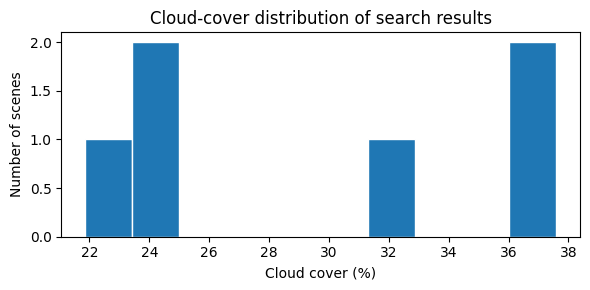

In [28]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(df['cloud_cover'].dropna(), bins=10, edgecolor='white')
ax.set_xlabel('Cloud cover (%)')
ax.set_ylabel('Number of scenes')
ax.set_title('Cloud-cover distribution of search results')
plt.tight_layout()
plt.show()

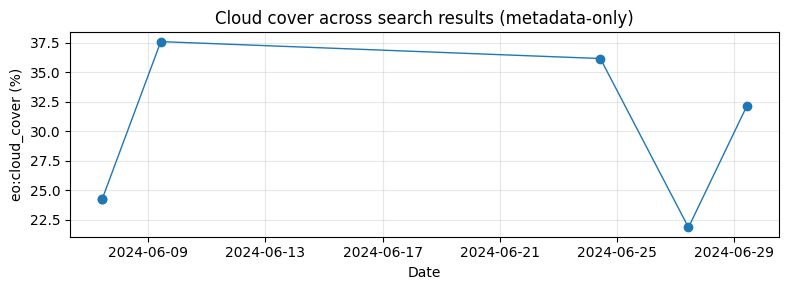

In [37]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(df["datetime"], df["cloud_cover"], marker="o", linewidth=1)
ax.set_xlabel("Date")
ax.set_ylabel("eo:cloud_cover (%)")
ax.set_title("Cloud cover across search results (metadata-only)")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



---

## 8) Preview a band from a STAC Item

We can load a single band directly from its COG URL using `rioxarray`.
We use `overview_level=3` (a coarse overview pyramid) so it downloads fast.

> **Note:** `rioxarray` extends xarray with rasterio-backed I/O.
> Install with `pip install rioxarray` if needed.

In [31]:
import rioxarray

# Pick the best (lowest-cloud) item
best_item = items[0]
red_url = best_item.assets['B04'].href

print(f'Loading red band (B04) from: {best_item.id}')
%time red_band = rioxarray.open_rasterio(red_url, overview_level=3)

print(f'Shape:  {red_band.shape}')
print(f'CRS:    {red_band.rio.crs}')
print(f'Bounds: {red_band.rio.bounds()}')


Loading red band (B04) from: S2A_MSIL2A_20240629T102021_R065_T32UNA_20240629T161655
CPU times: user 33.4 ms, sys: 17.2 ms, total: 50.6 ms
Wall time: 388 ms
Shape:  (1, 687, 687)
CRS:    EPSG:32632
Bounds: (499980.0, 5490240.000000001, 609780.0, 5600040.0)


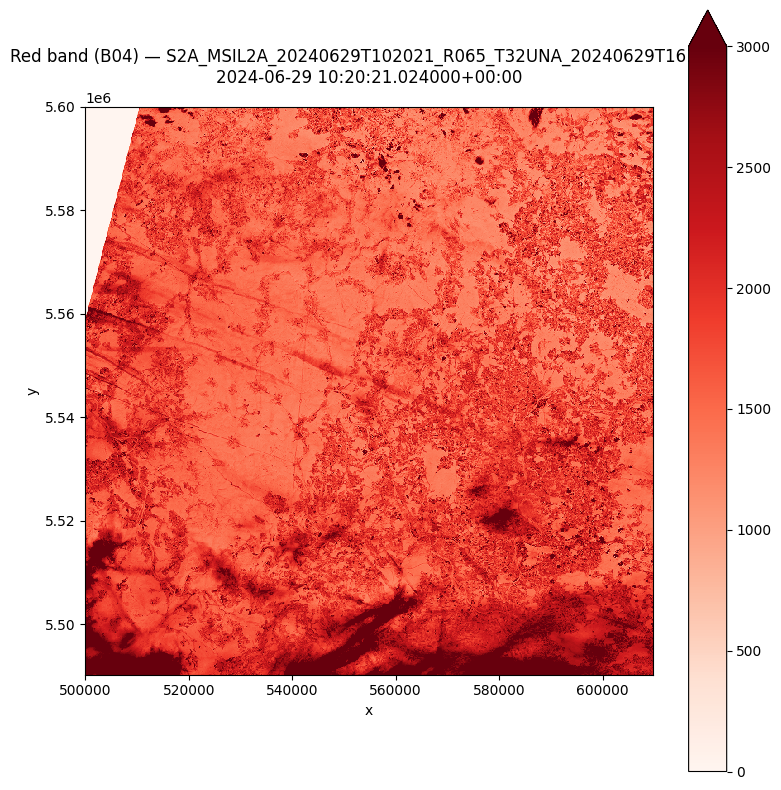

In [32]:
fig, ax = plt.subplots(figsize=(8, 8))
red_band.squeeze().plot(ax=ax, cmap='Reds', vmin=0, vmax=3000)
ax.set_title(f'Red band (B04) — {best_item.id}\n{best_item.datetime}')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

### 8.1 Display a thumbnail (if available)

Many STAC Items include a pre-rendered thumbnail or preview image as an Asset.

In [33]:
# Check for a rendered preview or thumbnail asset
preview_key = 'rendered_preview' if 'rendered_preview' in best_item.assets else 'thumbnail'

if preview_key in best_item.assets:
    from IPython.display import Image, display
    thumb_url = best_item.assets[preview_key].href
    print(f'Displaying: {preview_key}')
    display(Image(url=thumb_url, width=400))
else:
    print('No thumbnail or rendered_preview asset available for this item.')

Displaying: rendered_preview


---

## 9) Export results

Save the results table to CSV so you can reuse it later (e.g., in Notebook 05).

In [ ]:
out_csv = OUT_DIR / 'stac_search_results.csv'
df.to_csv(out_csv, index=False)
print(f'Saved {len(df)} rows to {out_csv.resolve()}')

## 10) Bonus: Pick the "best" scenes (metadata-only) + thumbnail contact sheet

We can use STAC metadata (e.g. `eo:cloud_cover`) to rank scenes without downloading any pixel data.
Then we can display the pre-rendered thumbnails that many Items provide as Assets.

In [43]:
# Bonus: server-side sort by cloud cover + show a thumbnail contact sheet
from IPython.display import HTML, display

best_search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=AOI_BBOX,
    datetime=DATE_RANGE,
    query={"eo:cloud_cover": {"lt": MAX_CLOUD}},
    sortby=[{"field": "eo:cloud_cover", "direction": "asc"}],
    limit=20,
    method="POST",  # POST is safer for longer/complex queries
)

best_items = list(best_search.items())
print("Returned items:", len(best_items))

# Quick sanity-check: print the top 5
for it in best_items[:5]:
    dt = it.properties.get("datetime", "N/A")
    cc = it.properties.get("eo:cloud_cover", None)
    cc_str = f"{cc:.1f}%" if isinstance(cc, (int, float)) else str(cc)
    print(f"{dt}  cloud={cc_str}  id={it.id}")

# Build an HTML contact sheet of thumbnails (no extra deps)
cards = []
for it in best_items[:12]:
    preview_key = "rendered_preview" if "rendered_preview" in it.assets else "thumbnail"
    if preview_key not in it.assets:
        continue

    url = it.assets[preview_key].href
    dt = it.properties.get("datetime", "N/A")
    cc = it.properties.get("eo:cloud_cover", None)
    cc_str = f"{cc:.1f}%" if isinstance(cc, (int, float)) else str(cc)

    cards.append(f"""
    <figure style="margin:8px; width:220px; font-family: sans-serif;">
      <img src="{url}" style="width:220px; border:1px solid #ddd;" />
      <figcaption style="font-size:12px; line-height:1.2; padding-top:4px;">
        <div><b>{cc_str}</b> cloud</div>
        <div style="opacity:0.8;">{dt}</div>
      </figcaption>
    </figure>
    """)

html = f"""
<div style="display:flex; flex-wrap:wrap; align-items:flex-start;">
  {''.join(cards) if cards else "<p>No thumbnail assets found in these results.</p>"}
</div>
"""
display(HTML(html))

Returned items: 6
2024-06-27T10:25:59.025000Z  cloud=21.8%  id=S2B_MSIL2A_20240627T102559_R108_T32UNA_20240627T142313
2024-06-07T10:25:59.025000Z  cloud=24.3%  id=S2B_MSIL2A_20240607T102559_R108_T32UNA_20240607T151842
2024-06-07T10:25:59.025000Z  cloud=24.3%  id=S2B_MSIL2A_20240607T102559_R108_T32UNA_20240607T133635
2024-06-29T10:20:21.024000Z  cloud=32.2%  id=S2A_MSIL2A_20240629T102021_R065_T32UNA_20240629T161655
2024-06-24T10:15:59.024000Z  cloud=36.2%  id=S2B_MSIL2A_20240624T101559_R065_T32UNA_20240624T145603


## 12) From STAC *discovery* to STAC *data cubes*


In this notebook you used STAC for **discovery**:

- search by **AOI + date range + cloud cover**
- inspect each **Item** (`properties`, geometry, projection)
- inspect **assets** (band COG URLs, thumbnails)
- preview a single band directly from a COG

This is ideal for *finding* good scenes and doing quick visual checks.  
However, once you want **time series analysis** (NDVI through time, monthly composites, anomalies, rolling means), it becomes cumbersome to juggle many Items + URLs one-by-one.

The usual “next step” is to turn the search results into a labeled **xarray** cube:

- **`odc-stac`**: loads a list of STAC Items into an `xarray.Dataset` (often the fastest path to an analysis-ready cube), with options like grouping by day and dask chunking for scale.
- **`stackstac`**: stacks selected STAC assets into an `xarray.DataArray` with cube-like dimensions such as `(time, band, y, x)` (very flexible and explicit).

**In short:** STAC helps you *discover* the right scenes; `stackstac` / `odc-stac` help you *turn those scenes into an xarray time-series cube* for analysis.


In [16]:
# If needed: !pip install odc-stac 

import matplotlib.pyplot as plt
from odc.stac import stac_load

# Load two bands as an xarray.Dataset, cropped to AOI_BBOX
ds_odc = stac_load(
    items,
    bands=["B04", "B08"],        # red, NIR (asset keys)
    bbox=AOI_BBOX,               # (west, south, east, north) in lon/lat
    crs=f"EPSG:32632",
    resolution=10,               # meters for Sentinel-2 10m bands
    groupby="solar_day",         # common grouping for Sentinel-2 time series
)

print(ds_odc)

<xarray.Dataset> Size: 16MB
Dimensions:      (y: 566, x: 728, time: 5)
Coordinates:
  * y            (y) float64 5kB 5.52e+06 5.52e+06 ... 5.515e+06 5.515e+06
  * x            (x) float64 6kB 5.683e+05 5.683e+05 ... 5.756e+05 5.756e+05
  * time         (time) datetime64[us] 40B 2024-06-07T10:25:59.025000 ... 202...
    spatial_ref  int32 4B 32632
Data variables:
    B04          (time, y, x) float32 8MB 1.288e+03 1.273e+03 ... 1.99e+03
    B08          (time, y, x) float32 8MB 5.192e+03 5.009e+03 ... 4.32e+03


---

## 11) Exercises

### ✅ Try it — Change the search parameters

1. Pick a **different AOI** — try a place you know.
   Look up approximate coordinates on [bboxfinder.com](http://bboxfinder.com).
2. Change the **time range** to a different month.
3. Tighten `MAX_CLOUD` to `10` — how many results do you get?

<details><summary>Show solution</summary>

```python
# Example: Munich area, July 2024, max 10 % cloud
my_bbox = (11.4, 48.05, 11.7, 48.25)
my_date_range = "2024-07-01/2024-07-31"
my_max_cloud = 10

my_search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=my_bbox,
    datetime=my_date_range,
    query={"eo:cloud_cover": {"lt": my_max_cloud}},
)
my_items = list(my_search.items())
print(f"Found {len(my_items)} items")

for it in my_items[:5]:
    dt = it.properties.get("datetime", "N/A")
    cc = it.properties.get("eo:cloud_cover", "N/A")
    print(f"  {dt}  —  cloud: {cc}%")
```

</details>

In [ ]:
# ✅ 1. Define your own bbox and time range
# ✅ 2. Search with MAX_CLOUD = 10
# ✅ 3. Print dates and cloud cover of the first 5 results


### ✅ Try it — Explore a different collection

Search for **Landsat** imagery instead of Sentinel-2.
The collection ID on Planetary Computer is `landsat-c2-l2`.

<details><summary>Show solution</summary>

```python
landsat_search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=AOI_BBOX,
    datetime=DATE_RANGE,
    query={"eo:cloud_cover": {"lt": MAX_CLOUD}},
)
landsat_items = list(landsat_search.items())
print(f"Found {len(landsat_items)} Landsat items")

for it in landsat_items[:5]:
    dt = it.properties.get("datetime", "N/A")
    cc = it.properties.get("eo:cloud_cover", "N/A")
    print(f"  {it.id}  —  {dt}  —  cloud: {cc}%")
```

</details>

In [ ]:
# ✅ Search for Landsat images over the same AOI and print results


### 🧠 Checkpoint

**Q1.** What does a STAC "Collection" represent?

- A) A single satellite image
- B) A group of related Items (e.g., all Sentinel-2 L2A scenes)
- C) A file like a GeoTIFF

**Q2.** How do you get the download URL for the red band of a STAC Item?

- A) `item.red.url`
- B) `item.assets['B04'].href`
- C) `item.properties['red']`

**Q3.** What does the `bbox` parameter in a STAC search represent?

- A) The pixel dimensions of the image
- B) The geographic bounding box `(west, south, east, north)` of the area of interest
- C) The cloud cover threshold

**Q4.** Why do we use `planetary_computer.sign_inplace` as a modifier?

- A) It converts images to PNG
- B) It signs the asset URLs so we can access the data without authentication tokens
- C) It compresses the search results

<details><summary>Show answers</summary>

1. **B** — A Collection groups related Items (e.g., all Sentinel-2 L2A scenes worldwide).
2. **B** — `item.assets['B04'].href` returns the signed URL to the red-band GeoTIFF.
3. **B** — `bbox` is `(west, south, east, north)` in geographic coordinates.
4. **B** — The modifier adds a Shared Access Signature so you can read the COGs without managing tokens yourself.

</details>

---

## 11) Recap

You now know how to:

| Skill | Tool / Code |
|-------|-------------|
| Connect to a STAC API | `pystac_client.Client.open(url)` |
| Search by area, time, cloud | `catalog.search(collections, bbox, datetime, query)` |
| Get Items from search | `list(search.items())` |
| Read Item metadata | `item.properties`, `item.datetime`, `item.bbox` |
| Access asset URLs | `item.assets['B04'].href` |
| Build a table from Items | Loop → list of dicts → `pd.DataFrame()` |
| Preview a band | `rioxarray.open_rasterio(url, overview_level=3)` |

### STAC hierarchy reminder

```
Catalog
 └── Collection  (e.g., sentinel-2-l2a)
      └── Item   (one scene on one date)
           └── Asset  (one file: B04.tif, thumbnail.png, …)
```